# NARMA10 DFR

## Import Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import shape
from numpy.core.function_base import linspace

## Define Mackey-Glass Transfer Function

[Mackey-Glass equation on Scholarpedia](http://www.scholarpedia.org/article/Mackey-Glass_equation)

$$
y = \frac{2 \times x}{0.8 + 0.2(2.1 \times x)^{10}}
$$

In [ ]:
def mg(x):

    a = 2
    b = 0.8
    c = 0.2
    d = 2.1
    p = 10

    return (a * x) / (b + c * np.power( (d * x), p) )

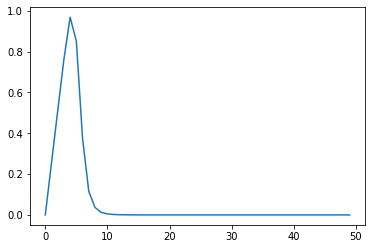

In [ ]:
inp_V = np.linspace(0, 5, 50)
out_V = mg(inp_V)
plt.plot(out_V)
plt.show()

## NARMA10 Sample Generation

In [ ]:
rng = np.random.default_rng(0)

# NARMA10
def narma10_create(inLen):

    # Compute the random uniform input matrix
    inp = 0.5*rng.random(inLen)

    # Compute the target matrix
    tar = np.zeros(inLen)

    for k in range(10,(inLen - 1)):
        tar[k+1] = 0.3 * tar[k] + 0.05 * tar[k] * np.sum(tar[k-9:k]) + 1.5 * inp[k] * inp[k - 9] + 0.1
    
    return (inp, tar)

## NARMA10 Samples

In [ ]:
init_samples = 200
train_samples = 6000
test_samples = 14000

num_samples = init_samples + train_samples + test_samples

x, y = narma10_create(num_samples)
y_train = y[init_samples:init_samples+train_samples]
y_test = y[init_samples + train_samples:init_samples+train_samples+test_samples]

## DFR Parameters

In [ ]:
N = 50
gamma = 0.5
eta = 0.4
LAST_NODE = N - 1
reg = 1e-8

## Mask Generation

In [ ]:
mask = rng.uniform(-0.5,0.5,N)

masked_samples = np.empty((num_samples,N))
for i in range(num_samples):
    masked_samples[i] = mask * x[i]

# DFR Training Initialization

In [ ]:
reservoir = np.zeros(N)
reservoir_history = np.zeros((train_samples,N))
for i in range(init_samples):
    for j in range(N):
        g_i = mg(gamma * masked_samples[i][j] + eta * reservoir[LAST_NODE])
        reservoir[1:N] = reservoir[0:LAST_NODE]
        reservoir[0] = g_i

## DFR Training Data Stage

In [ ]:
y_hat = np.zeros(train_samples)
for i in range(train_samples):
    for j in range(N):

        g_i = mg(gamma * masked_samples[i + init_samples][j] + eta * reservoir[LAST_NODE])
        reservoir[1:N] = reservoir[0:LAST_NODE]
        reservoir[0] = g_i

    reservoir_history[i] = reservoir

Calculate DFT weights using gradient descent

In [ ]:
def weight_derivative(weights, feature_matrix, labels):
    # Input:
    # weights: weight vector w, a numpy vector of dimension d
    # feature_matrix: numpy array of size n by d, where n is the number of data points, and d is the feature dimension
    # labels: true labels y, a numpy vector of dimension d
    # Output:
    # Derivative of the regression cost function with respect to the weight w, a numpy array of dimension d
    n = len(feature_matrix) +1
    LD_sum = 0
    ## STUDENT: Start of code ###
    np.shape(feature_matrix)
    for i in range(1, len(feature_matrix)):
      LD = np.multiply(np.subtract(labels[i], np.multiply(weights,feature_matrix[i])),-1*feature_matrix[i])
      LD_sum = LD + LD_sum
    
    LD_sum = LD_sum * 2/n
    return LD_sum
    # End of code ###

In [ ]:
def regression_gradient_descent(feature_matrix, labels, initial_weights, step_size, tolerance):
    # Gradient descent algorithm for linear regression problem    
    
    # Input:
    # feature_matrix: numpy array of size n by d, where n is the number of data points, and d is the feature dimension
    # labels: true labels y, a numpy vector of dimension d
    # initial_weights: initial weight vector to start with, a numpy vector of dimension d
    # step_size: step size of update
    # tolerance: tolerace epsilon for stopping condition
    # Output:
    # Weights obtained after convergence

    converged = False 
    weights = np.array(initial_weights) # current iterate
    i = 0
    while not converged:
        i += 1
        # STUDENT: Start of code: your impelementation of what the gradient descent algorithm does in every iteration
        # Refer back to the update rule listed above: update the weight
        if i >1:
          last_gradient = gradient_magnitude
          LD_deri = weight_derivative(next_w, feature_matrix, labels)
        else:
          LD_deri =  weight_derivative(weights, feature_matrix, labels)
          next_w = np.subtract(weights, np.multiply(LD_deri, step_size))
        
        # Compute the gradient magnitude:
        gradient_magnitude = np.sqrt(LD_deri.dot(LD_deri))
        
        if i ==1:
          last_gradient = gradient_magnitude
        # Check the stopping condition to decide whether you want to stop the iterations
        if  last_gradient <= tolerance:           # STUDENT: check the stopping condition here
            converged = True
            weights = next_w
        if i>1 :
          next_w = next_w - (LD_deri*step_size)
        # End of code
        if i ==1:
          print ("Iteration: ",i,"gradient_magnitude: ", gradient_magnitude) # for us to check about convergence
        else:
          print ("Iteration: ",i,"gradient_magnitude: ", last_gradient) # for us to check about convergence
        
    return(weights)

In [ ]:
# x1= [0.0008,0.0008, 0.0007, 0.0004, 0.0004, 0.0001]
# x2 = [2, 2, 3, 4, 4.1, 4.75]
# y = [27, 22, 17, 7, 6, 0.29]
# plt.plot(x1, y)
# plt.title("relation between step size and loss")
# plt.xlabel("step size")
# plt.ylabel("loss")

In [ ]:
# plt.plot(x2, y)
# plt.title("relation between tolerance and loss")
# plt.xlabel("tolerance")
# plt.ylabel("loss")

In [ ]:
from sklearn.linear_model import SGDRegressor
clf = SGDRegressor(max_iter=1000, tol=1e-3)
clf.fit(reservoir_history, y_train)
#y_pred = clf.predict(X_test)
W = clf.coef_

In [ ]:
# #initial_weights = np.random.randn(50)* np.sqrt(2/50)
# initial_weights = rng.random(N) #(0.0005,6.7) = 3.18 (0.0005,7) = 0.7 (0.001, 8.8) = 10.8 (0.0005, 8) = 1.5 (0.0005, 7.5) = 1.6
# step_size = 0.0005 #(0.0008, 2)= 27; (0.0008, 2)= 22; (0.0007, 3)= 17; (0.0004, 4)= 7; (0.0004, 4.1)= 6; (0.0001, 4.75)= 0.29
# tolerance = 6.7
# # end of code

# # Use the regression_gradient_descent function to calculate the gradient decent and store it in the variable 'final_weights'
# W = regression_gradient_descent(reservoir_history, y_train, initial_weights, step_size, tolerance)

# # end of code
# print ("Here are the final weights after convergence:")
# print (W)

## Calculate DFR Readout Weights using Ridge Regression

$$
W = \frac{\hat{y} \cdot X}{X^{T} \cdot X + \lambda I}
$$

In [ ]:
# W = np.dot(np.dot(y_train,reservoir_history),np.linalg.inv((np.dot(reservoir_history.T,reservoir_history)) + reg * np.eye(N)))
# print(W)

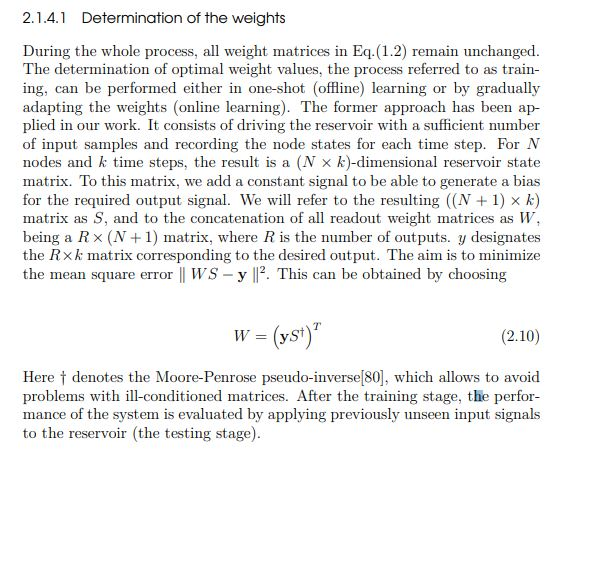

In [ ]:
# #Original weight fucntion without regularization
# W = rng.random(N)
# S = np.linalg.pinv(reservoir_history)
# for i in range(len(S)):
#  W[i] =  np.transpose(np.dot(y_train, S[i]))


## Training Data Accuracy

Ridge Regression NRMSE:	0.2609193740823345


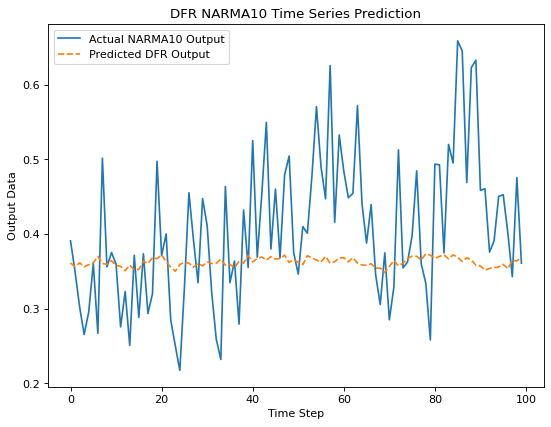

In [ ]:
y_hat_reg = reservoir_history.dot(W)
loss = (np.linalg.norm(y_train - y_hat_reg) / np.linalg.norm(y_train))
#loss = np.sqrt(np.multiply(1/len(y_hat_reg),np.divide(np.sum(np.square(y_hat_reg - y_train)),np.square(np.std(y_train)))) )#Ruizhe's edit
print(f"Ridge Regression NRMSE:\t{loss}")
#print(f"Original NRMSE:\t{loss}")
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(y_train[0:100],label="Actual NARMA10 Output")
plt.plot(y_hat_reg[0:100],'--',label="Predicted DFR Output")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Output Data")
plt.title("DFR NARMA10 Time Series Prediction")
plt.show()

## DFR Testing Data Stage

In [ ]:
# reservoir_history = np.zeros((test_samples,N))
# y_hat = np.zeros(test_samples)
# for i in range(test_samples):
#     for j in range(N):

#         g_i = mg(gamma * masked_samples[i + init_samples + train_samples][j] + eta * reservoir[LAST_NODE])
#         reservoir[1:N] = reservoir[0:LAST_NODE]
#         reservoir[0] = g_i

#     reservoir_history[i] = reservoir

## Testing Data Accuracy

In [ ]:
# y_hat_reg = reservoir_history.dot(W)
# loss = (np.linalg.norm(y_test - y_hat_reg) / np.linalg.norm(y_test))
# #loss = np.sqrt(np.multiply(1/len(y_hat_reg),np.divide(np.sum(np.square(y_hat_reg - y_test)),np.square(np.std(y_test)))) )#Ruizhe's edit
# print(f"Ridge Regression NRMSE:\t{loss}")
# #print(f"Original NRMSE:\t{loss}")
# plt.figure(figsize=(8, 6), dpi=80)
# plt.plot(y_test[0:100],label="Actual NARMA10 Output")
# plt.plot(y_hat_reg[0:100],'--',label="Predicted DFR Output")
# plt.legend()
# plt.xlabel("Time Step")
# plt.ylabel("Output Data")
# plt.title("DFR NARMA10 Time Series Prediction")
# plt.show()